In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import sys 
import os


root_path = 'C://Users//HP//projects//DiplomaThesis'
sys.path.append(f'{root_path}')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from figures import Results
import figures
import utils
import itertools
import seaborn as sns

In [3]:
from data import Meta 
meta = Meta() 
meta.load()

In [4]:
r = Results('results/all/ensembles')
r.load(adjust_index=False)
r.rename(['nn_name'])

dfs_to_plot = {
    'ig':r.ig.groupby(r.ar.nn_name).mean().transpose()*100,
    'mr':r.mr.groupby(r.ar.nn_name).mean().transpose(),
    'pr':r.pr.groupby(r.ar.nn_name).mean().transpose()*100}

vmins = {
    'ig':0,
    'mr':1,
    'pr':0
}

SORTINGS = {
    'ig': dfs_to_plot.get('ig')[["NN1","NN2","NN3","NN4"]].mean(axis=1).sort_values(ascending=False).index,
    'mr': dfs_to_plot.get('mr')[["NN1","NN2","NN3","NN4"]].mean(axis=1).sort_values(ascending=False).index,
    'pr': dfs_to_plot.get('pr')[["NN1","NN2","NN3","NN4"]].mean(axis=1).sort_values(ascending=False).index,
}

# Descriptives of target variable

In [3]:
from data import MinMaxed
dt = MinMaxed()
dt.load()

In [87]:
r = dt.targets.r*100

In [88]:
r_without_outliers = r[np.abs((r - r.mean())/r.std(ddof=0)<8)] 

C:\Users\HP\Anaconda3\envs\ths\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Figure saved to latex/Figures/returns_descriptives.pdf


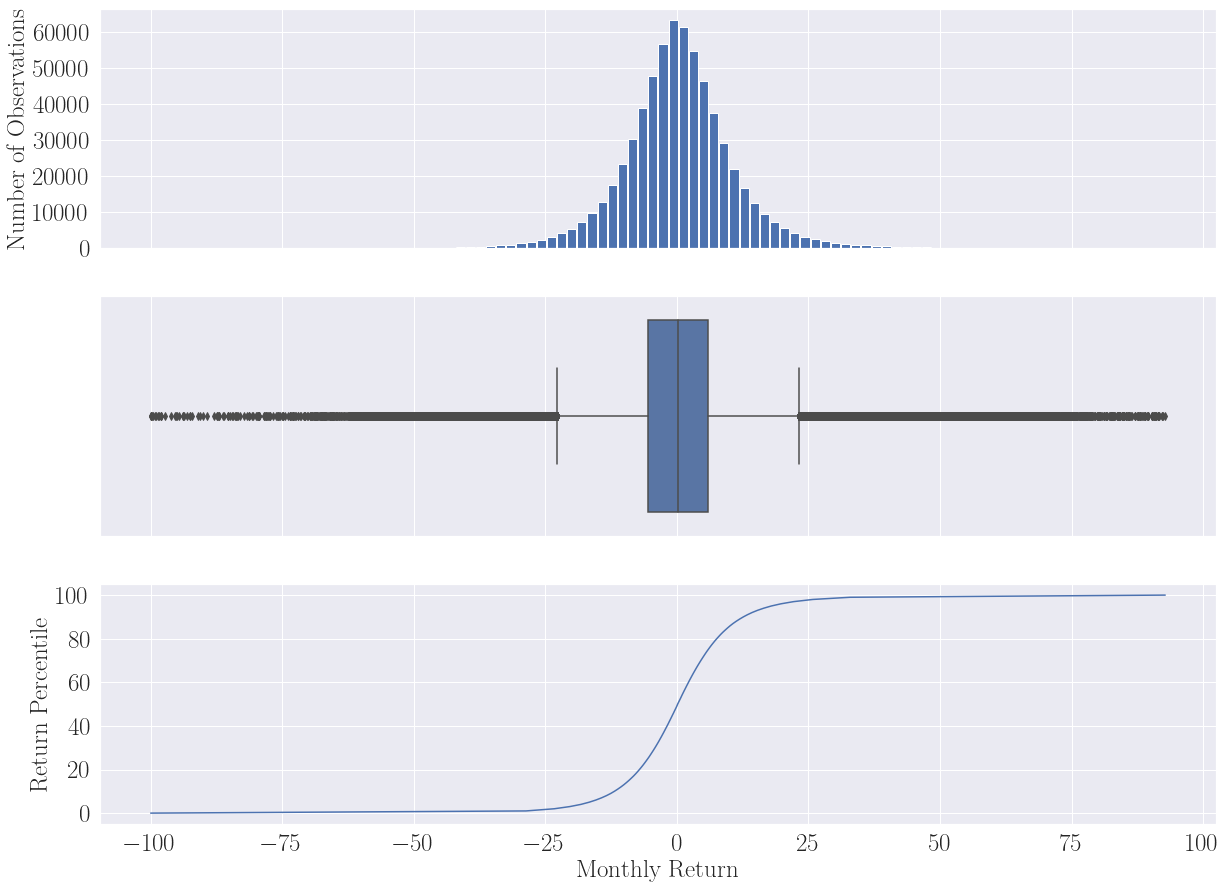

In [114]:
fig, axes = plt.subplots(nrows=3,ncols=1, sharex=True, figsize=(20,15))
fontsize = 25

# Histogram 
r_without_outliers.plot.hist(grid=True, bins=100, rwidth=0.9, ax=axes[0])
axes[0].set_ylabel('Number of Observations', fontsize = fontsize)

# Boxplot
sns.boxplot(x=r_without_outliers, ax=axes[1])

# Deciles 
out, percentiles = pd.qcut(r_without_outliers,100, retbins=True)
percentiles = pd.DataFrame(percentiles, index = list(range(0,101,1)),columns=["r"])
percentiles.reset_index(inplace=True)
percentiles.plot(x="r",y="index", ax = axes[2], legend=False)
axes[2].set_ylabel('Return Percentile', fontsize = fontsize)

# Common x label 
plt.xlabel("Monthly Return", fontsize = fontsize)

# Increase font size of ticks
for ax in axes:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

# Convert to LatexFigure
fig = figures.LatexFigure(fig)
fig.fig.show()
fig.save('latex/Figures/returns_descriptives.pdf')

In [121]:
df = pd.DataFrame(r_without_outliers.describe()[1:]).round(3).transpose()
df.columns = ["Mean", "Std", "Min", "25%", "50%", "75%", "Max"]
df.index = ["Return"]
tab = figures.LatexTable(df)
tab.save('latex/Tables/return_descriptives.tex')

Table  saved to latex/Tables/return_descriptives.tex


In [122]:
out, bins = pd.qcut(r_without_outliers,10,retbins=True)
bins = bins[1:-1]
deciles = pd.DataFrame(bins,index=["{}%".format(i) for i in list(range(10,100,10))])
df = deciles.round(3).transpose()
df.index = ["Return"]
tab = figures.LatexTable(df)
tab.save('latex/Tables/return_deciles.tex')

Table  saved to latex/Tables/return_deciles.tex


# Local feature importance

In [5]:
lig = figures.LocalIG('models/nn1/ensembles', hidden_layers="32")

lig.load(sorting=SORTINGS.get('ig').values.tolist())
lig.df = lig.df*100

In [91]:
from data import MinMaxed
dt = MinMaxed()
dt.load()

In [92]:
features = dt.features.loc[lig.df.index]
features = features[lig.df.columns.tolist()]

Figure saved to latex/Figures/ig_coefs.pdf


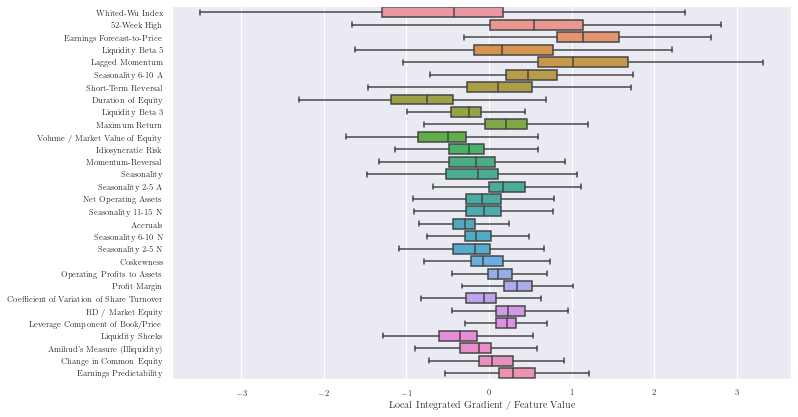

In [126]:
coefs = lig.df / features

fig, axes = plt.subplots(1,1)
axis = sns.boxplot(data=coefs, orient="h", showfliers=False)

# Axis Labels
axis.set_xlabel("Local Integrated Gradient / Feature Value")
axis.set_ylabel("")

# Y ticks 
labels = [meta.sc_to_latex.get(label) for label in list(coefs.columns)]
axis.set_yticklabels(labels)

# Convert to LatexFigure to change font and figsize
fig = figures.LatexFigure(plt.gcf())
fig.fit(scale=2)
fig.save('latex/Figures/ig_coefs.pdf') 

In [134]:
coefs = lig.df / features
coefs = coefs.describe().transpose()
coefs = coefs[["mean", "std"]]
coefs["Mean / Std"] = coefs["mean"] / coefs["std"]

df = meta.signals[meta.signals["important_otmh_global_liquid"]<=30][["sc", "sign"]]
df.set_index("sc", inplace=True)
coefs = coefs.join(df)

coefs["Sign (Here)"] = np.sign(coefs["mean"]).astype(int)
coefs.rename(columns={"mean":"Mean", "std":"Std", "sign":"Sign (Original)"}, inplace=True)

coefs.index = [meta.sc_to_latex.get(s) for s in coefs.index]
coefs = coefs.round(3)

tab = figures.LatexTable(coefs)
tab.save("latex/Tables/coefs.tex")

Table  saved to latex/Tables/coefs.tex


In [128]:
coefs

,Mean,Std,Mean / std,Sign,Mean Sign
Whited-Wu Index,-0.830,1.951,-0.425,1,-1
52-Week High,0.457,1.392,0.328,1,1
Earnings Forecast-to-Price,1.222,0.617,1.980,1,1
Liquidity Beta 5,0.528,1.397,0.378,1,1
Lagged Momentum,1.222,0.889,1.374,1,1
Seasonality 6-10 A,0.488,0.630,0.774,1,1
Short-Term Reversal,0.093,0.787,0.118,-1,1
Duration of Equity,-0.850,0.692,-1.228,-1,-1
Liquidity Beta 3,-0.294,0.377,-0.782,-1,-1
Maximum Return,0.235,0.582,0.404,-1,1


In [121]:
coefs["Mean Sign Agrees"].sum()

22

Figure saved to latex/Figures/ig_boxplot.pdf


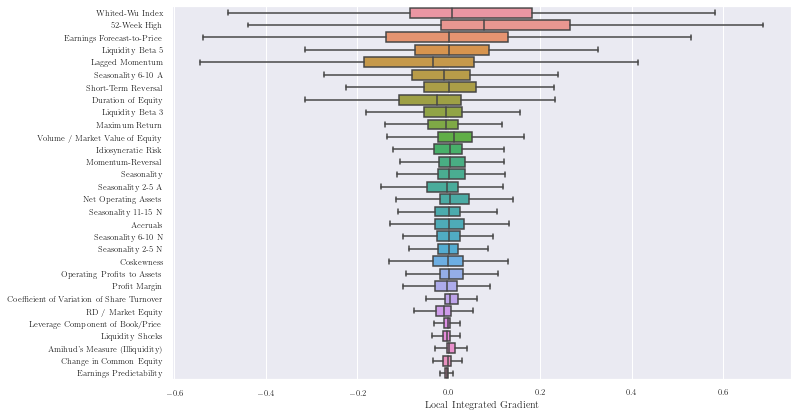

In [66]:
df = lig.df

fig, axes = plt.subplots(1,1)
axis = sns.boxplot(data=df, orient="h", showfliers=False)

# Axis Labels
axis.set_xlabel("Local Integrated Gradient")
axis.set_ylabel("")

# Y ticks 
labels = [meta.sc_to_latex.get(label) for label in list(df.columns)]
axis.set_yticklabels(labels)

# Convert to LatexFigure to change font and figsize
fig = figures.LatexFigure(plt.gcf())
fig.fit(scale=2)
fig.save('latex/Figures/ig_boxplot.pdf')

Figure saved to latex/Figures/local_ig_1.pdf
Figure saved to latex/Figures/local_ig_100.pdf


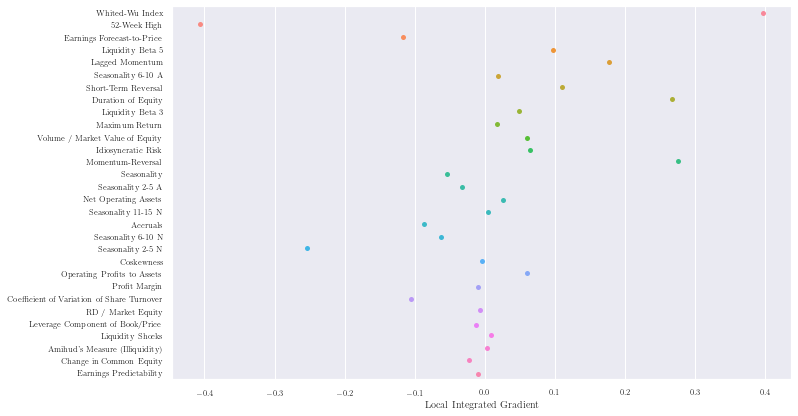

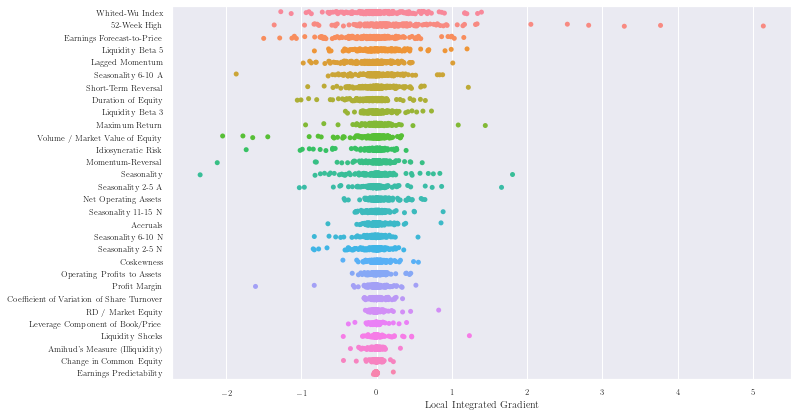

In [71]:
lig.plot_all_observations(lig.df[:1],xlabel="Local Integrated Gradient", p ="latex/Figures/local_ig_1.pdf")
lig.plot_all_observations(lig.df.sample(200),xlabel="Local Integrated Gradient", p ="latex/Figures/local_ig_100.pdf")

# Calculate backtest, tabulate and plot results

Table  saved to latex/Tables/backtest_descriptives_models.tex
Figure saved to latex/Figures/backtest_cumreturns_models.pdf


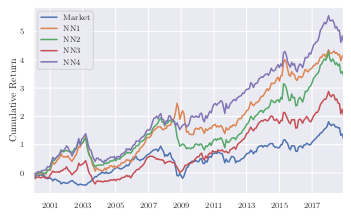

In [466]:
import backtest
paths_to_backtests = ['models/nn1/ensembles','models/nn2/ensembles','models/nn3/ensembles','models/nn4/ensembles']

# This calculates the backtest if not already calculated
"""
from data import MinMaxed
from nets import Nets
dt = MinMaxed()
dt.load() 
for p in ['models/nn3/ensembles','models/nn4/ensembles', 'models/lr/ensembles']:
    models = Nets.from_saved(p)
    _ = [net.set_dataset(dt, ytest=1) for net in models.nets]
    for net in models.nets: 
        backtest = net.backtest()
        path = net.__repr__().split(": ")[1]
        backtest.to_csv(os.path.join(p, path, 'backtest.csv'))
"""
hl_dict = {
    'models/nn1/ensembles':'32',
    'models/nn2/ensembles':'32,16',
    'models/nn3/ensembles':'32,16,8',
    'models/nn4/ensembles':'32,16,8,4', 
    'models/lr/ensembles':'-1'}

# Tabulate backtest descriptive models
metrics = dict()
for p in paths_to_backtests:
    _, _, ret, market  = backtest.get_returns(p, hl_dict.get(p), percent_long=10, percent_short=10)
    m = backtest.get_metrics_single_model(ret)
    m_market = backtest.get_metrics_single_model(market)
    metrics["Market"] = m_market
    metrics[figures.NN_DICT.get(hl_dict.get(p))] = m
df = pd.DataFrame(metrics)
df = df.round(3)
tab = figures.LatexTable(df)
tab.save('latex/Tables/backtest_descriptives_models.tex')

# PLot backtest cumreturns models
returns = dict() 
for  p in paths_to_backtests:
    _, _, ret, market  = backtest.get_cumulative_returns(p, hl_dict.get(p), 10, 10)
    returns["Market"] = market
    returns[figures.NN_DICT.get(hl_dict.get(p))] = ret
df = pd.DataFrame(returns)

axis = df.plot()
axis.set_ylabel("Cumulative Return")
axis.set_xlabel("")
fig = figures.LatexFigure(plt.gcf())
fig.fit()
fig.save('latex/Figures/backtest_cumreturns_models.pdf')

In [500]:
figures.tabulate_backtest_descriptives_ls('models/nn1/ensembles', "32",p="latex/Tables/backtest_descriptives_ls.tex")

Table  saved to latex/Tables/backtest_descriptives_ls.tex


,Market,0.5-0.5,1-1,5-5,10-10,20-20
Mean,0.005,0.025,0.028,0.019,0.014,0.011
Mean (Yearly),0.072,0.408,0.440,0.262,0.191,0.145
Standard Deviation,0.051,0.111,0.082,0.053,0.043,0.033
Sharpe Ratio,0.325,0.773,1.196,1.226,1.160,1.171
Skewness,-0.633,-0.085,-0.144,-0.192,-0.148,-0.215
Kurtosis,2.118,0.262,0.982,2.273,2.640,4.265
Max Drawdown,-0.584,-0.826,-0.567,-0.263,-0.225,-0.181


In [501]:
backtest.get_nfirms_in_portfolios('models/nn1/ensembles', "32")

{'0.5': 8, '1': 17, '5': 88, '10': 177, '20': 355}

Figure saved to latex/Figures/dummy.pdf
Figure saved to latex/Figures/backtest_histogram.pdf


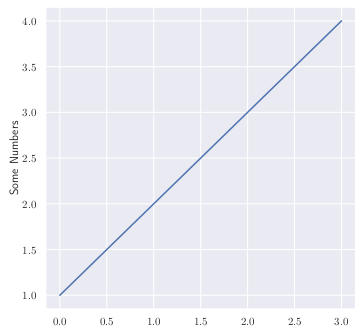

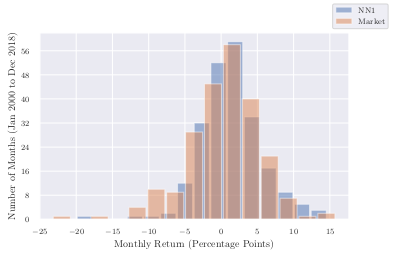

In [468]:
figures.plot_dummy(p="latex/Figures/dummy.pdf")
figures.plot_backtest_histogram('models/nn1/ensembles', "32", p = "latex/Figures/backtest_histogram.pdf")

# Calculate decile performance

In [317]:
"""
from data import MinMaxed
from nets import Nets
dt = MinMaxed()
dt.load() 

for p in ['models/lr/ensembles','models/nn2/ensembles','models/nn3/ensembles','models/nn4/ensembles']:
    models = Nets.from_saved(p)
    [net.set_dataset(dt,ytest=1) for net in models.nets]
    models.decile_performance().to_csv(os.path.join(p, 'decile_performance.csv'))
"""

1691/1691 [==============================] - 0s 0s/sample - loss: 0.0186 - root_mean_squared_error: 0.1363 - mean_absolute_error: 0.0989 - r_square: 0.0049


2354/2354 [==============================] - 0s 16us/sample - loss: 0.0075 - root_mean_squared_error: 0.0866 - mean_absolute_error: 0.0607 - r_square: -0.0071


2124/2124 [==============================] - 0s 0s/sample - loss: 0.0228 - root_mean_squared_error: 0.1510 - mean_absolute_error: 0.1140 - r_square: -0.0277


2317/2317 [==============================] - 0s 8us/sample - loss: 0.0157 - root_mean_squared_error: 0.0999 - mean_absolute_error: 0.0704 - r_square: 0.0415


2038/2038 [==============================] - 0s 8us/sample - loss: 0.0192 - root_mean_squared_error: 0.1152 - mean_absolute_error: 0.0832 - r_square: 0.0069


2452/2452 [==============================] - 0s 9us/sample - loss: 0.0110 - root_mean_squared_error: 0.0899 - mean_absolute_error: 0.0662 - r_square: -0.0055


1645/1645 [==============================] - 0s 13us/sample - loss: 0.0246 - root_mean_squared_error: 0.1136 - mean_absolute_error: 0.0783 - r_square: 0.0080


2363/2363 [==============================] - 0s 13us/sample - loss: 0.0259 - root_mean_squared_error: 0.0752 - mean_absolute_error: 0.0558 - r_square: 0.0107


1902/1902 [==============================] - 0s 16us/sample - loss: 0.0163 - root_mean_squared_error: 0.1030 - mean_absolute_error: 0.0733 - r_square: 0.0918


2737/2737 [==============================] - 0s 8us/sample - loss: 0.0147 - root_mean_squared_error: 0.1068 - mean_absolute_error: 0.0775 - r_square: -0.0022


2029/2029 [==============================] - 0s 15us/sample - loss: 0.0265 - root_mean_squared_error: 0.1009 - mean_absolute_error: 0.0698 - r_square: 0.0179


1691/1691 [==============================] - 0s 19us/sample - loss: 0.0226 - root_mean_squared_error: 0.1132 - mean_absolute_error: 0.0820 - r_square: 0.0109


2354/2354 [==============================] - 0s 20us/sample - loss: 0.0094 - root_mean_squared_error: 0.0749 - mean_absolute_error: 0.0555 - r_square: -0.0133


2125/2125 [==============================] - 0s 22us/sample - loss: 0.0478 - root_mean_squared_error: 0.1728 - mean_absolute_error: 0.1265 - r_square: -0.0422


1666/1666 [==============================] - 0s 23us/sample - loss: 0.0246 - root_mean_squared_error: 0.1141 - mean_absolute_error: 0.0800 - r_square: 0.0619


# Aggregate results

In [ ]:
"""
# ENSEMBLES
r_nn1 = Results('results/nn1/ensembles')  
r_nn2 = Results('results/nn2/ensembles')  
r_nn3 = Results('results/nn3/ensembles')  
r_nn4 = Results('results/nn4/ensembles')
r_lr = Results('results/lr/ensembles')  

for r in [r_lr, r_nn1, r_nn2, r_nn3, r_nn4]: 
    r.load()

ar = pd.concat([r_lr.ar, r_nn1.ar, r_nn2.ar, r_nn3.ar, r_nn4.ar])
pe = pd.concat([r_lr.pe, r_nn1.pe, r_nn2.pe, r_nn3.pe, r_nn4.pe])
ig = pd.concat([r_lr.ig, r_nn1.ig, r_nn2.ig, r_nn3.ig, r_nn4.ig])
mr = pd.concat([r_lr.mr, r_nn1.mr, r_nn2.mr, r_nn3.mr, r_nn4.mr])
pr = pd.concat([r_lr.pr, r_nn1.pr, r_nn2.pr, r_nn3.pr, r_nn4.pr])
dp =  pd.concat([r_lr.dp, r_nn1.dp, r_nn2.dp, r_nn3.dp, r_nn4.dp])

ar.to_csv('results/all/ensembles/args.csv')
pe.to_csv('results/all/ensembles/performance.csv')
ig.to_csv('results/all/ensembles/integrated_gradients_global_test.csv')
mr.to_csv('results/all/ensembles/model_reliance_test.csv')
pr.to_csv('results/all/ensembles/portfolio_reliance.csv')
dp.to_csv('results/all/ensembles/decile_performance.csv')

# SEEDS
r_nn1 = Results('results/nn1/seeds')  
r_nn2 = Results('results/nn2/seeds')  
r_nn3 = Results('results/nn3/seeds')  
r_nn4 = Results('results/nn4/seeds')  

for r in [r_nn1, r_nn2, r_nn3, r_nn4]: 
    r.load()

ar = pd.concat([r_nn1.ar, r_nn2.ar, r_nn3.ar, r_nn4.ar])
pe = pd.concat([r_nn1.pe, r_nn2.pe, r_nn3.pe, r_nn4.pe])
ig = pd.concat([r_nn1.ig, r_nn2.ig, r_nn3.ig, r_nn4.ig])
mr = pd.concat([r_nn1.mr, r_nn2.mr, r_nn3.mr, r_nn4.mr])
pr = pd.concat([r_nn1.pr, r_nn2.pr, r_nn3.pr, r_nn4.pr])

ar.to_csv('results/all/seeds/args.csv')
pe.to_csv('results/all/seeds/performance.csv')
ig.to_csv('results/all/seeds/integrated_gradients_global_test.csv')
mr.to_csv('results/all/seeds/model_reliance_test.csv')
pr.to_csv('results/all/seeds/portfolio_reliance.csv')
"""

# Performance

In [387]:
r_all = Results('results/all/ensembles')
r_all.load(adjust_index=False)

In [469]:
# Tabulate Performance (MSE, R2,...)
dp = r_all.dp.groupby(r_all.ar.nn_name).median().transpose()
dp["decile"] = [s.split("_")[0] for s in dp.index.values.tolist()]
dp["measure"] = ["_".join(s.split("_")[1:]) for s in dp.index.values.tolist()]
dp = dp.groupby('measure').mean()
dp = dp.loc[["mae", "mse", "rmse","r2"]]
dp.index=["Mean Absolute Error", "Mean Squared Error", "Root Mean Squared Error", "R Square"]
dp = dp[["NN1","NN2", "NN3", "NN4"]]
dp.columns = ["NN1","NN2", "NN3", "NN4"]
dp.loc["R Square"] = dp.loc["R Square"] * 100
dp = dp.round(3)
tab = figures.LatexTable(dp)
tab.save('latex/Tables/performance.tex')

Table  saved to latex/Tables/performance.tex


Figure saved to latex/Figures/r2.pdf


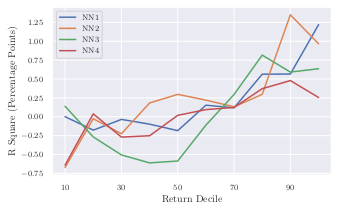

In [450]:
# Plot R2 across deciles
dp = r_all.dp.groupby(r_all.ar.nn_name).median().transpose()
dp["decile"] = [s.split("_")[0] for s in dp.index.values.tolist()]
dp["measure"] = ["_".join(s.split("_")[1:]) for s in dp.index.values.tolist()]
dp = dp[dp['measure']=="r2"]
dp.set_index(["decile"],inplace=True)
dp = dp[["NN1","NN2", "NN3", "NN4"]]
dp.columns = ["NN1","NN2", "NN3", "NN4"]
dp = dp*100
dp.plot(xlabel="Return Decile", ylabel="R Square (Percentage Points)")
fig = figures.LatexFigure(plt.gcf())
fig.save('latex/Figures/r2.pdf')

# Ensemble interpretability

Figure saved to latex/Figures/ig_blues.pdf
Figure saved to latex/Figures/mr_blues.pdf
Figure saved to latex/Figures/pr_blues.pdf
Table  saved to latex/Tables/ig_blues.tex
Table  saved to latex/Tables/mr_blues.tex
Table  saved to latex/Tables/pr_blues.tex
Figure saved to latex/Figures/ig_order.pdf
Figure saved to latex/Figures/mr_order.pdf
Figure saved to latex/Figures/pr_order.pdf
Figure saved to latex/Figures/ig_relative.pdf
Figure saved to latex/Figures/mr_relative.pdf
Figure saved to latex/Figures/pr_relative.pdf
Figure saved to latex/Figures/ig_relative_without_lr.pdf
Figure saved to latex/Figures/mr_relative_without_lr.pdf
Figure saved to latex/Figures/pr_relative_without_lr.pdf


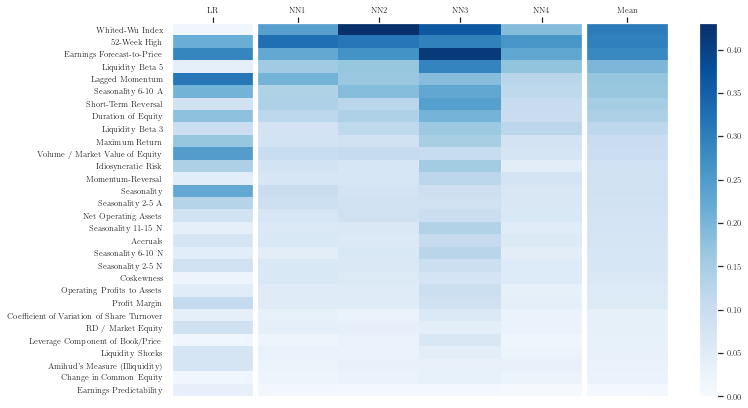

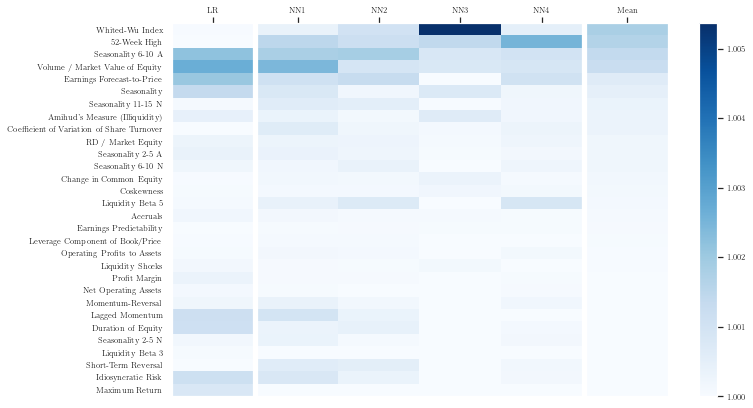

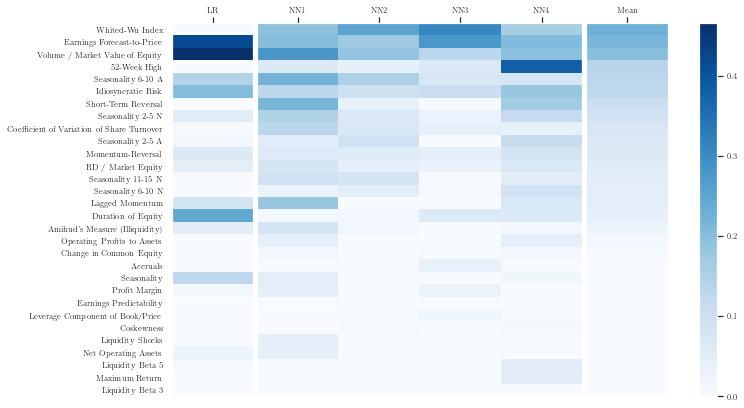

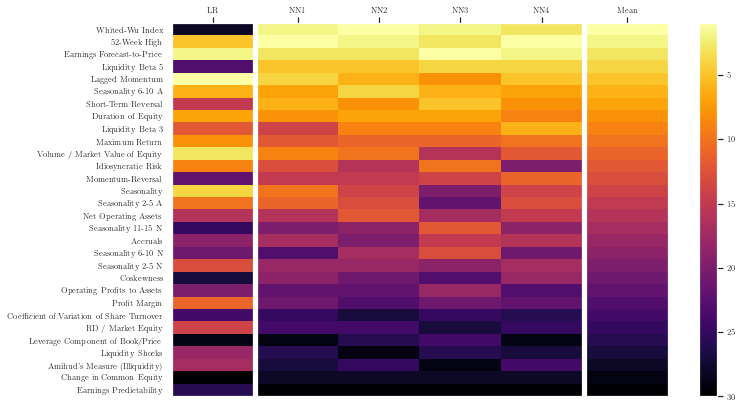

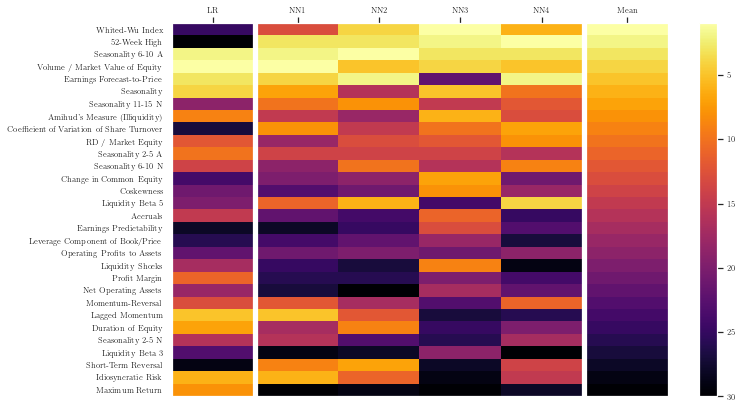

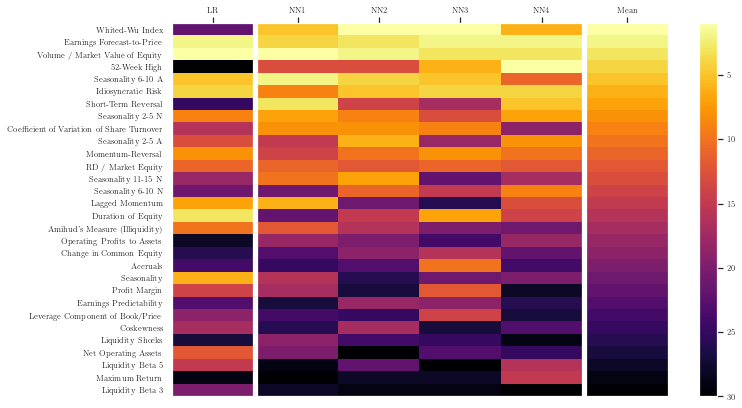

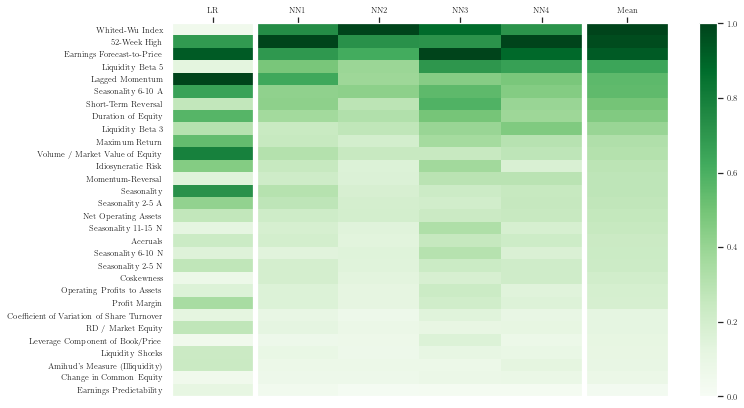

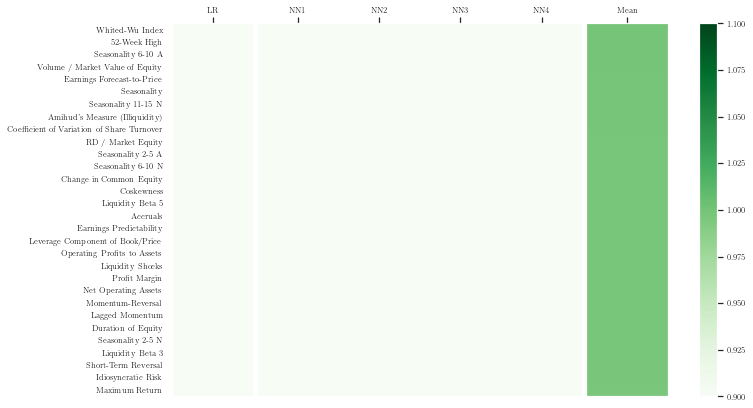

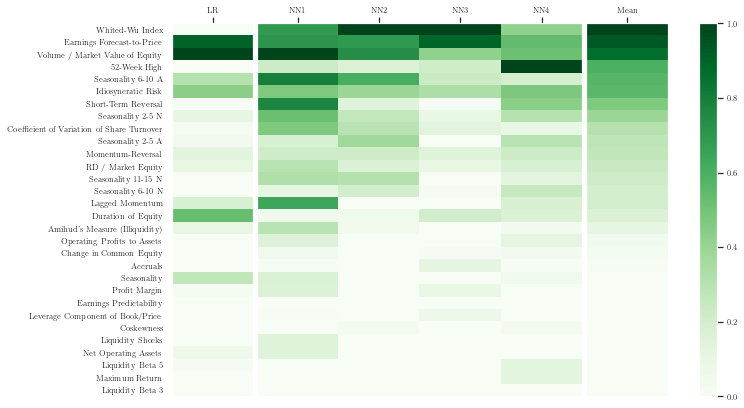

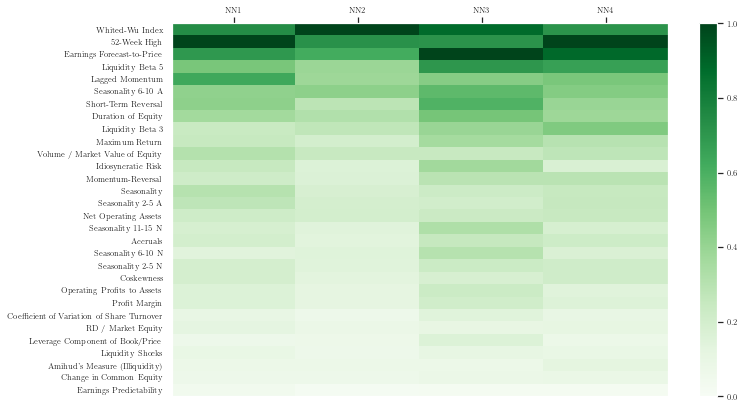

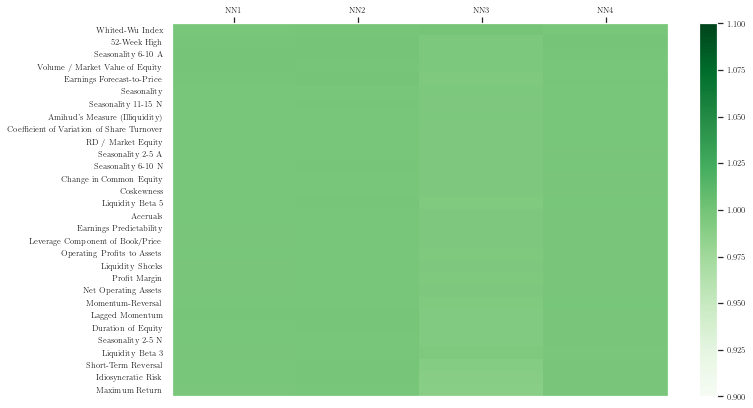

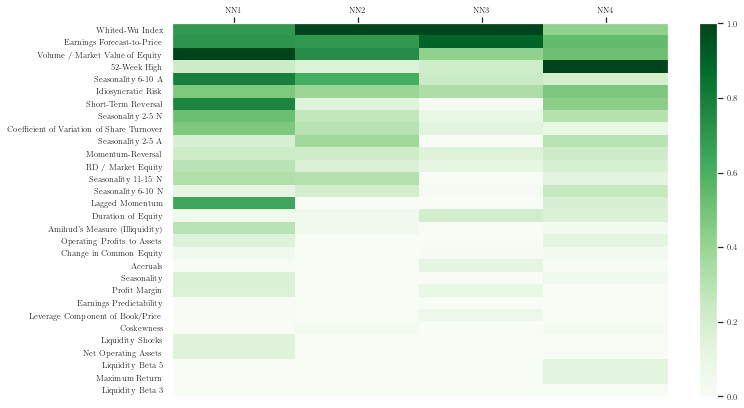

In [141]:
# MAIN RESULTS
r = Results('results/all/ensembles')
r.load(adjust_index=False)
r.rename(['nn_name'])

dfs_to_plot = {
    'ig':r.ig.groupby(r.ar.nn_name).mean().transpose()*100,
    'mr':r.mr.groupby(r.ar.nn_name).mean().transpose(),
    'pr':r.pr.groupby(r.ar.nn_name).mean().transpose()*100}

vmins = {
    'ig':0,
    'mr':1,
    'pr':0
}

SORTINGS = {
    'ig': dfs_to_plot.get('ig')[["NN1","NN2","NN3","NN4"]].mean(axis=1).sort_values(ascending=False).index,
    'mr': dfs_to_plot.get('mr')[["NN1","NN2","NN3","NN4"]].mean(axis=1).sort_values(ascending=False).index,
    'pr': dfs_to_plot.get('pr')[["NN1","NN2","NN3","NN4"]].mean(axis=1).sort_values(ascending=False).index,
}

for name, df in dfs_to_plot.items(): 
    df["Mean"] = df[["NN1","NN2","NN3","NN4"]].mean(axis=1)


# blues (with vmin)
for name, df in dfs_to_plot.items(): 
    fig = figures._plot_df(
                df.loc[SORTINGS.get(name)], column_groups=[["LR"],["NN1", "NN2", "NN3", "NN4"], ["Mean"]], group_xticks=False, 
                cmap=plt.cm.Blues, flip_cbar=False, show_cbar=True, 
                vmin=vmins.get(name), convert_labels=True)
    fig.save('latex/Figures/{}_blues.pdf'.format(name))

for name, df in dfs_to_plot.items(): 
    df = df.loc[SORTINGS.get(name)]
    df.index = [meta.sc_to_latex.get(s) for s in df.index.values.tolist()]
    df.columns = ["LR", "NN1", "NN2", "NN3", "NN4", "Mean"]
    df = df.round(3)
    tab = figures.LatexTable(df)
    tab.save('latex/Tables/{}_blues.tex'.format(name))


# order
for name, df in dfs_to_plot.items():
    df = figures.Styling.order(df)
    fig = figures._plot_df(
                df.loc[SORTINGS.get(name)], column_groups=[["LR"],["NN1", "NN2", "NN3", "NN4"], ["Mean"]], group_xticks=False, 
                cmap=plt.cm.inferno_r, flip_cbar=True, show_cbar=True, 
                vmin=None, convert_labels=True)
    fig.save('latex/Figures/{}_order.pdf'.format(name))


# relative
for name, df in dfs_to_plot.items(): 
    df = figures.Styling.relative(df)
    fig = figures._plot_df(
                df.loc[SORTINGS.get(name)], column_groups=[["LR"],["NN1", "NN2", "NN3", "NN4"], ["Mean"]], group_xticks=False, 
                cmap=plt.cm.Greens, flip_cbar=False, show_cbar=True, 
                vmin=vmins.get(name), convert_labels=True)
    fig.save('latex/Figures/{}_relative.pdf'.format(name))


# relative without LR
for name, df in dfs_to_plot.items(): 
    df = figures.Styling.relative(df)
    fig = figures._plot_df(
                df.loc[SORTINGS.get(name)], column_groups=[["NN1", "NN2", "NN3", "NN4"]], group_xticks=False, 
                cmap=plt.cm.Greens, flip_cbar=False, show_cbar=True, 
                vmin=vmins.get(name), convert_labels=True)
    fig.save('latex/Figures/{}_relative_without_lr.pdf'.format(name))

In [140]:
dfs_to_plot.get("ig")

nn_name,LR,NN1,NN2,NN3,NN4,Mean
52WH,0.216157,0.324892,0.310923,0.296532,0.261469,0.298454
WWI,0.017006,0.241263,0.430240,0.364296,0.187140,0.305735
EFoP,0.290378,0.226017,0.266117,0.412778,0.231209,0.284030
MomLag,0.312951,0.205854,0.164793,0.185732,0.125695,0.170518
LB5,0.040514,0.158397,0.168957,0.290857,0.174239,0.198112
STR,0.083719,0.138338,0.124185,0.243075,0.103310,0.152227
Seas6t10A,0.205604,0.137137,0.185332,0.227711,0.118627,0.167202
DurE,0.178787,0.120392,0.139112,0.204745,0.100510,0.141190
VolMV,0.247100,0.101855,0.107438,0.103168,0.072575,0.096259
Seas,0.226612,0.099483,0.080067,0.093778,0.065860,0.084797


Figure saved to latex/Figures/ig_pr_comparison.pdf


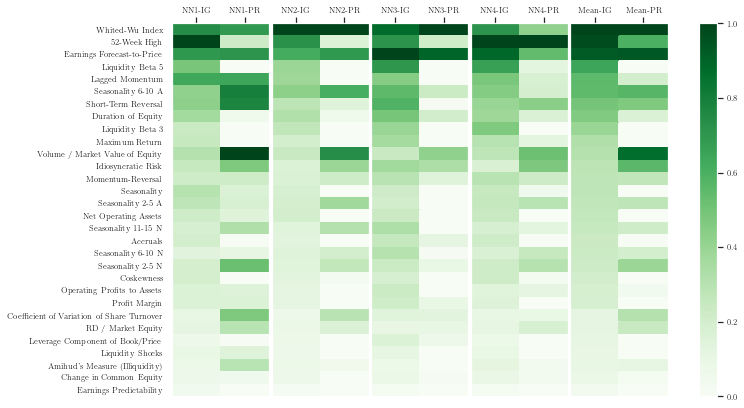

In [144]:
# COMPARISON OF INTEGRATED GRADIENTS AND PORTFOLIO RELIANCE

r = Results('results/all/ensembles')
r.load(adjust_index=False)
r.rename(['nn_name'])

ig = r.ig.groupby(r.ar.nn_name).mean().transpose()*100
pr = r.pr.groupby(r.ar.nn_name).mean().transpose()*100
ig = ig[["NN1","NN2","NN3","NN4"]]
ig["Mean"] = ig.mean(axis=1)
ig.columns = ["NN1-IG","NN2-IG","NN3-IG","NN4-IG", "Mean-IG"]
pr = pr[["NN1","NN2","NN3","NN4"]]
pr["Mean"] = pr.mean(axis=1)
pr.columns = ["NN1-PR","NN2-PR","NN3-PR","NN4-PR", "Mean-PR"]

df = pd.concat([ig,pr],axis=1)
df = df.loc[SORTINGS.get('ig')]

df = figures.Styling.relative(df)
fig = figures._plot_df(
            df, column_groups=[["NN1-IG", "NN1-PR"], ["NN2-IG","NN2-PR"], ["NN3-IG","NN3-PR"], ["NN4-IG","NN4-PR"],["Mean-IG","Mean-PR"]], group_xticks=False, 
            cmap=plt.cm.Greens, flip_cbar=False, show_cbar=True, 
            vmin=0, convert_labels=True)
fig.save('latex/Figures/ig_pr_comparison.pdf')

Figure saved to latex/Figures/ig_time_relative.pdf
Figure saved to latex/Figures/mr_time_relative.pdf
Figure saved to latex/Figures/pr_time_relative.pdf
Figure saved to latex/Figures/ig_time_relative_mean.pdf
Figure saved to latex/Figures/mr_time_relative_mean.pdf
Figure saved to latex/Figures/pr_time_relative_mean.pdf


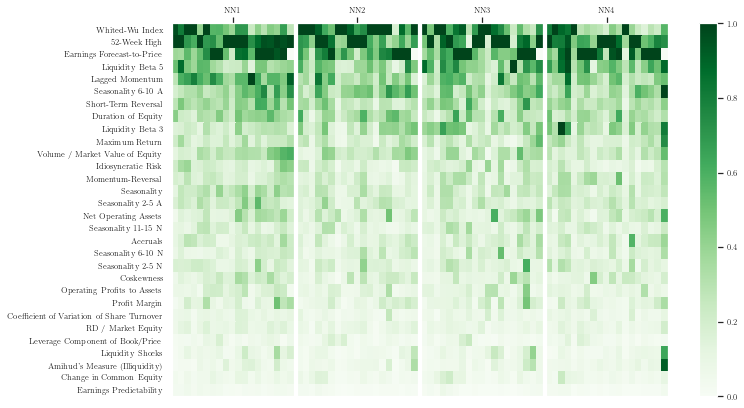

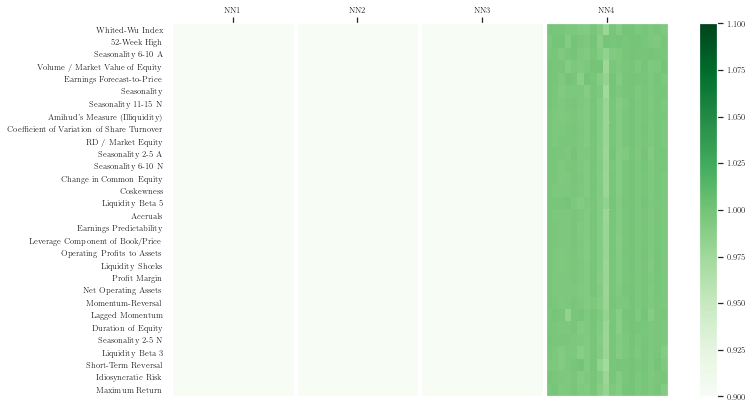

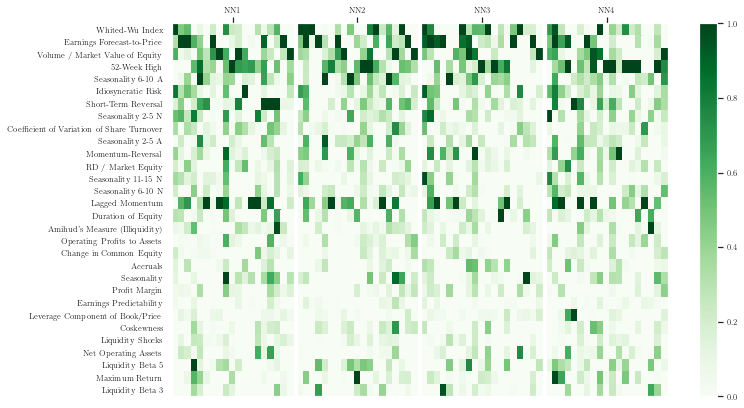

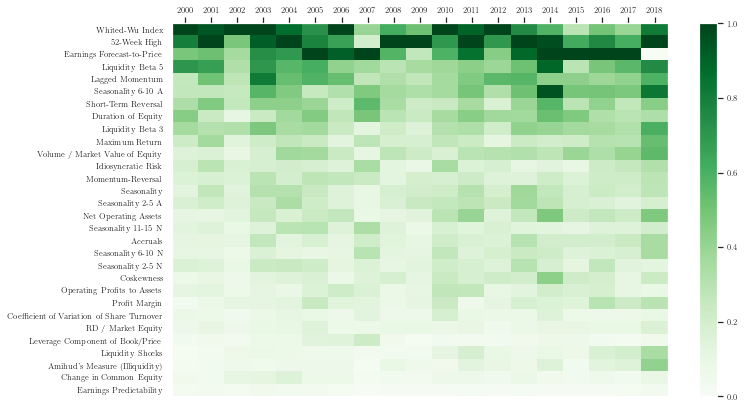

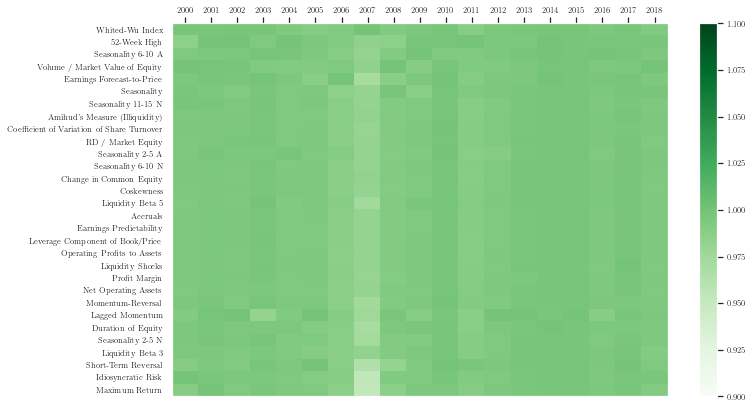

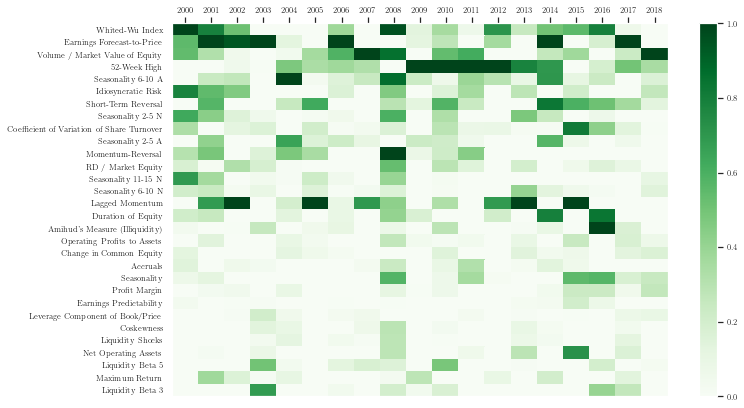

In [159]:
# TIME DECOMPOSITION
r = Results('results/all/ensembles')
r.load(adjust_index=False)
r.rename(['nn_name', 'ytrain'])
r.subset("hidden_layers",["32","32,16","32,16,8","32,16,8,4"])

dfs_to_plot = {
    'ig': r.ig.transpose(),
    'mr': r.mr.transpose(),
    'pr': r.pr.transpose()
}

for name, df in dfs_to_plot.items(): 
    df = figures.Styling.relative(df)
    column_groups = list(
        utils.chunks(["{}-{}".format(n,s) for n,s in itertools.product(
            figures.NN_NAMES[1:],figures.YTRAIN_NAMES)],figures.N_YTRAIN))
    fig = figures._plot_df(
                df.loc[SORTINGS.get(name)], column_groups=column_groups, group_xticks=True, 
                cmap=plt.cm.Greens, flip_cbar=False, show_cbar=True, 
                vmin=vmins.get(name), convert_labels=True)
    fig.save('latex/Figures/{}_time_relative.pdf'.format(name))

dfs_to_plot = {
    'ig': r.ig.groupby(r.ar["ytrain"]).mean().transpose(),
    'mr': r.mr.groupby(r.ar["ytrain"]).mean().transpose(),
    'pr': r.pr.groupby(r.ar["ytrain"]).mean().transpose()
}

for name, df in dfs_to_plot.items(): 
    df = figures.Styling.relative(df)
    df.columns = [str(i) for i in dfs_to_plot.get("ig").columns.tolist()]
    df.rename(columns=figures.YTRAIN_NAMES_TO_TEST_YEAR, inplace=True)
    fig = figures._plot_df(
                df.loc[SORTINGS.get(name)], column_groups=None, group_xticks=False, 
                cmap=plt.cm.Greens, flip_cbar=False, show_cbar=True, 
                vmin=vmins.get(name), convert_labels=True)
    fig.save('latex/Figures/{}_time_relative_mean.pdf'.format(name))


In [432]:
r = Results('results/all/seeds')

In [433]:
r.load(adjust_index=False)

File results/all/seeds/decile_performance.csv not found, skipping


In [434]:
r.rename(['nn_name', 'ytrain', 'seed'])

In [446]:
ig = r.ig.groupby([r.ar.nn_name, r.ar.seed]).mean()
ig.index = ["{}-{}".format(n,s) for n,s in itertools.product(figures.NN_NAMES[1:],figures.SEED_NAMES)]
ig = ig.transpose()

mr = r.mr.groupby([r.ar.nn_name, r.ar.seed]).mean()
mr.index = ["{}-{}".format(n,s) for n,s in itertools.product(figures.NN_NAMES[1:],figures.SEED_NAMES)]
mr = mr.transpose()

pr = r.pr.groupby([r.ar.nn_name, r.ar.seed]).mean()
pr.index = ["{}-{}".format(n,s) for n,s in itertools.product(figures.NN_NAMES[1:],figures.SEED_NAMES)]
pr = pr.transpose()

Figure saved to latex/Figures/ig_seeds_relative.pdf
Figure saved to latex/Figures/mr_seeds_relative.pdf
Figure saved to latex/Figures/pr_seeds_relative.pdf


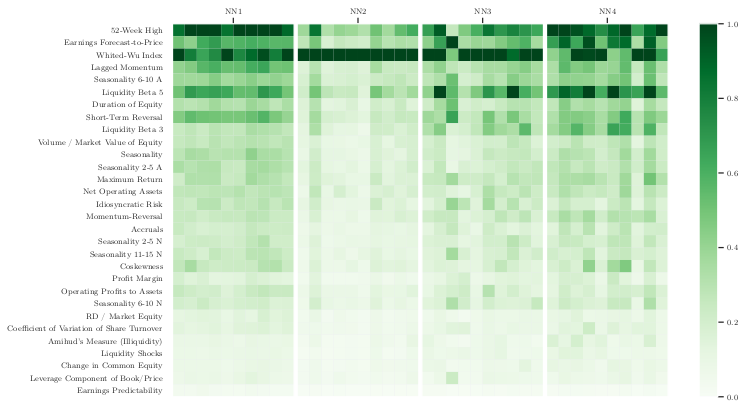

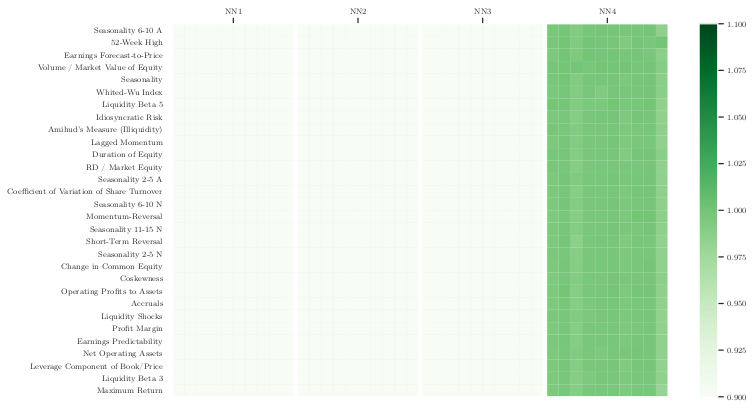

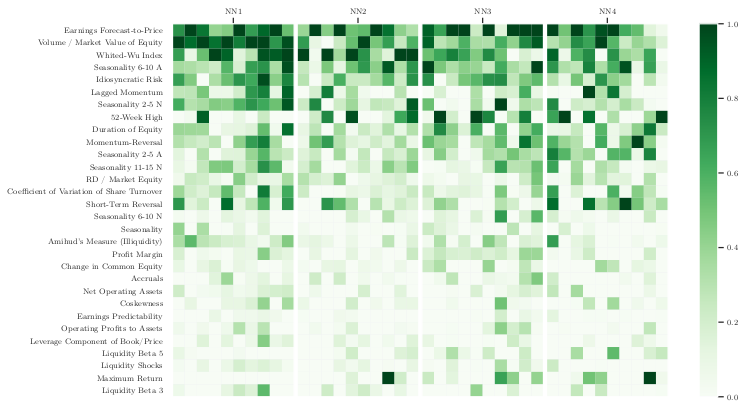

In [448]:
dfs_to_plot = {
    'ig': ig,
    'mr': mr,
    'pr': pr
}

for name, df in dfs_to_plot.items(): 
    df = figures.Styling.relative(df)
    column_groups = list(
        utils.chunks(["{}-{}".format(n,s) for n,s in itertools.product(figures.NN_NAMES[1:],figures.SEED_NAMES)],figures.N_SEEDS))
    fig = figures._plot_df(
                df.loc[SORTINGS.get(name)], column_groups=column_groups, group_xticks=True, 
                cmap=plt.cm.Greens, flip_cbar=False, show_cbar=True, 
                vmin=vmins.get(name), convert_labels=True)
    fig.save('latex/Figures/{}_seeds_relative.pdf'.format(name))